In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer, average_precision_score
import numpy as np
from sklearn import metrics
from collections import Counter
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("nts_data.csv")

In [4]:
df

mode_main  distance  density  age male ethnicity education  income  \
0           walk       1.0  1.26259   84   no    native     lower  less20   
1           walk      10.0  1.26259   84   no    native     lower  less20   
2            car       3.0  1.76264   27  yes   western    middle  20to40   
3            car       3.0  1.76264   27  yes   western    middle  20to40   
4            car      61.5  1.76264   27  yes   western    middle  20to40   
...          ...       ...      ...  ...  ...       ...       ...     ...   
230603      bike       5.0  0.92743   59   no    native     lower  20to40   
230604      bike       2.0  0.92743   59   no    native     lower  20to40   
230605       car       2.0  0.94175   57   no    native     lower  20to40   
230606       car       8.0  0.94175   57   no    native     lower  20to40   
230607       car       8.0  0.39012   57   no    native     lower  20to40   

        cars license  bicycles weekend  diversity      green  temp  precip  \
0          0     yes         1     yes    1.24604  26.881233   0.1    0.10   
1          0     yes         1     yes    1.24604  26.881233   0.1    0.10   
2          1     yes         2     yes    1.53959  36.045955  -3.4    0.05   
3          1     yes         2     yes    1.53959  36.045955  -3.4    0.05   
4          1     yes         2     yes    1.53959  36.045955  -3.4    0.05   
...      ...     ...       ...     ...        ...        ...   ...     ...   
230603     1     yes         1     yes    2.29996  57.150087  11.9    0.90   
230604     1     yes         1     yes    2.29996  57.150087  11.9    0.90   
230605     1     yes         2     yes    2.09674  71.413992  12.1    1.40   
230606     1     yes         2     yes    2.09674  71.413992  12.1    1.40   
230607     1     yes         2     yes    2.09674  71.413992  12.1    1.40   

        wind  
0        3.0  
1        3.0  
2        1.8  
3        1.8  
4        1.8  
...      ...  
230603   7.8  
230604   7.8  
230605   6.4  
230606   6.4  
230607   6.4  

[230608 rows x 17 columns]

In [5]:
value_counts = df['mode_main'].value_counts()
print(value_counts)

mode_main
car     127439
bike     56298
walk     37571
pt        9300
Name: count, dtype: int64


In [6]:
df.describe()

distance        density            age           cars  \
count  230608.000000  230608.000000  230608.000000  230608.000000   
mean       12.217913       1.569055      47.661356       1.382584   
std        23.545686       1.593292      15.934884       0.822056   
min         0.100000       0.001840      18.000000       0.000000   
25%         1.500000       0.591320      36.000000       1.000000   
50%         4.000000       1.153210      47.000000       1.000000   
75%        12.000000       1.952960      60.000000       2.000000   
max       400.000000      11.442960      98.000000      10.000000   

            bicycles      diversity          green           temp  \
count  230608.000000  230608.000000  230608.000000  230608.000000   
mean        3.357134       1.774927      54.939470      13.316930   
std         1.936614       0.493037      22.172372       7.565732   
min         0.000000       0.000000       0.000000      -9.000000   
25%         2.000000       1.388940      37.111200       8.000000   
50%         3.000000       1.827390      54.102123      13.400000   
75%         4.000000       2.172380      74.381844      19.000000   
max        10.000000       2.827560      97.813002      35.900000   

              precip           wind  
count  230608.000000  230608.000000  
mean        2.184633       4.097702  
std         4.674801       1.914821  
min         0.000000       0.400000  
25%         0.000000       2.700000  
50%         0.100000       3.800000  
75%         2.300000       5.100000  
max       142.300000      16.300000

In [6]:
print(df.columns)

Index(['mode_main', 'distance', 'density', 'age', 'male', 'ethnicity',
       'education', 'income', 'cars', 'license', 'bicycles', 'weekend',
       'diversity', 'green', 'temp', 'precip', 'wind'],
      dtype='object')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230608 entries, 0 to 230607
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mode_main  230608 non-null  object 
 1   distance   230608 non-null  float64
 2   density    230608 non-null  float64
 3   age        230608 non-null  int64  
 4   male       230608 non-null  object 
 5   ethnicity  230608 non-null  object 
 6   education  230608 non-null  object 
 7   income     230608 non-null  object 
 8   cars       230608 non-null  int64  
 9   license    230608 non-null  object 
 10  bicycles   230608 non-null  int64  
 11  weekend    230608 non-null  object 
 12  diversity  230608 non-null  float64
 13  green      230608 non-null  float64
 14  temp       230608 non-null  float64
 15  precip     230608 non-null  float64
 16  wind       230608 non-null  float64
dtypes: float64(7), int64(3), object(7)
memory usage: 29.9+ MB


In [8]:
df.isnull().any()

mode_main    False
distance     False
density      False
age          False
male         False
ethnicity    False
education    False
income       False
cars         False
license      False
bicycles     False
weekend      False
diversity    False
green        False
temp         False
precip       False
wind         False
dtype: bool

<Axes: xlabel='age', ylabel='distance'>

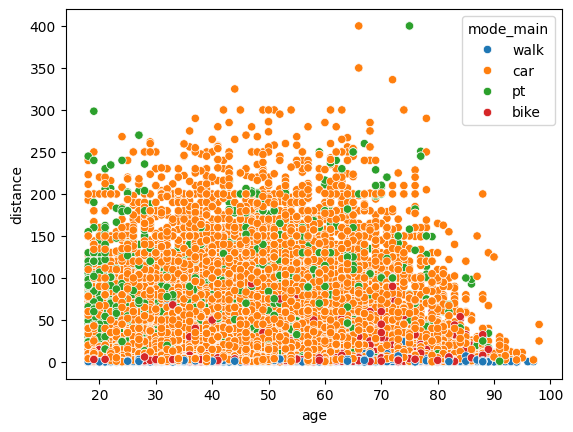

In [18]:
sns.scatterplot(x='age', y='distance', hue="mode_main", data=df)

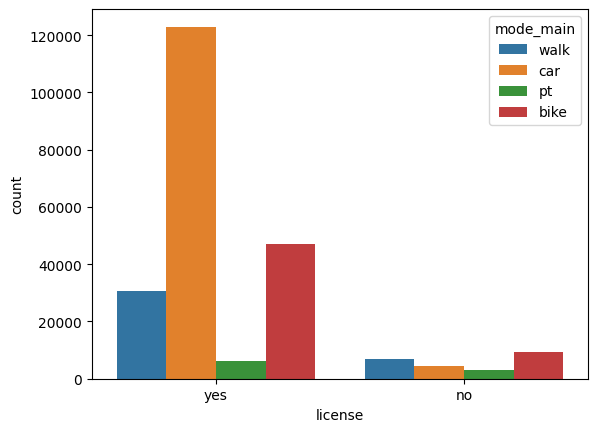

In [27]:
sns.countplot(x='license', data=df, hue="mode_main")
plt.show()

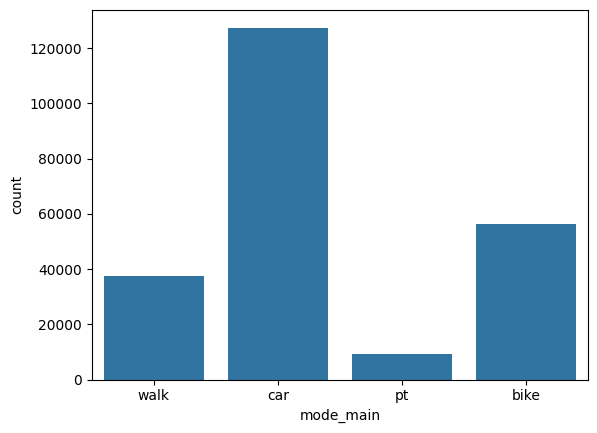

In [29]:
sns.countplot(x='mode_main', data=df)
plt.show()

In [21]:
percentage_mode = (df['mode_main'].value_counts(normalize=True) * 100).reset_index()
print(percentage_mode)

  mode_main  proportion
0       car   58.669935
1      bike   22.401071
2      walk   14.223154
3        pt    4.705840


<Axes: xlabel='age', ylabel='distance'>

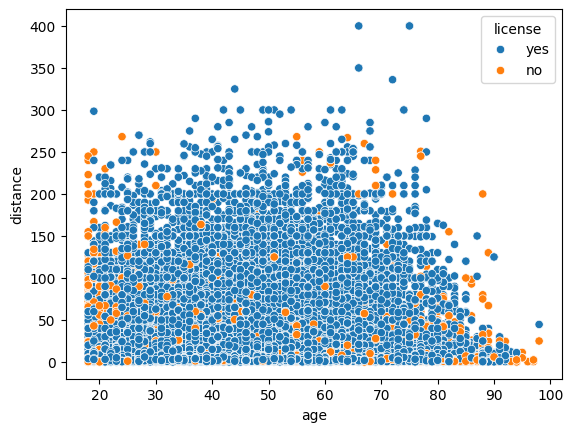

In [25]:
sns.scatterplot(x='age', y='distance', hue="license", data=df)

<Axes: xlabel='precip', ylabel='distance'>

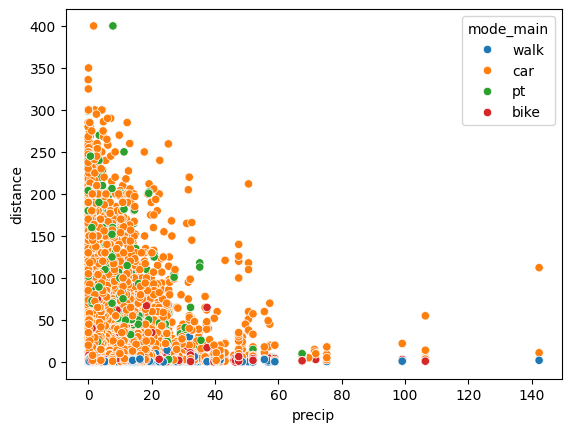

In [33]:
sns.scatterplot(x='precip', y='distance', hue="mode_main", data=df)

<Axes: xlabel='wind', ylabel='distance'>

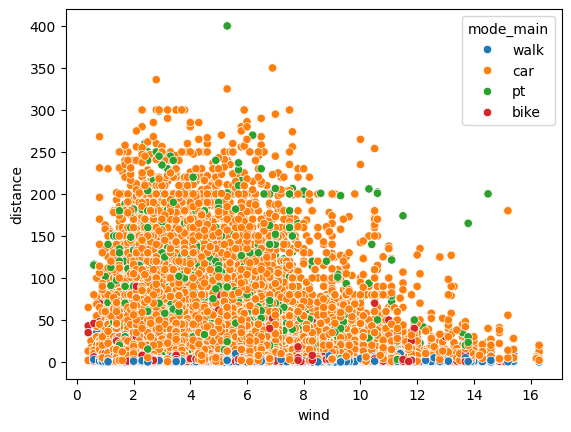

In [34]:
sns.scatterplot(x='wind', y='distance', hue="mode_main", data=df)

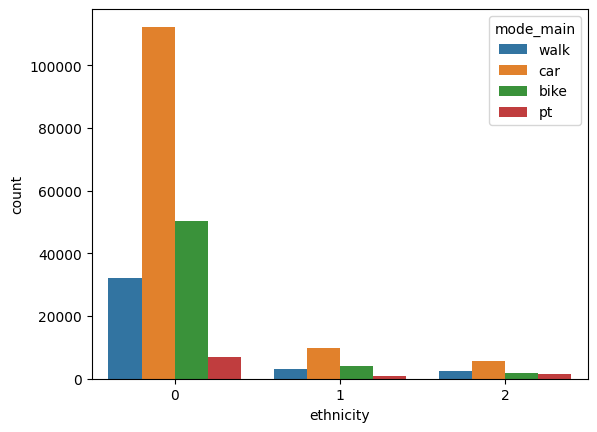

In [11]:
sns.countplot(x='ethnicity', data=df, hue="mode_main")
plt.show()

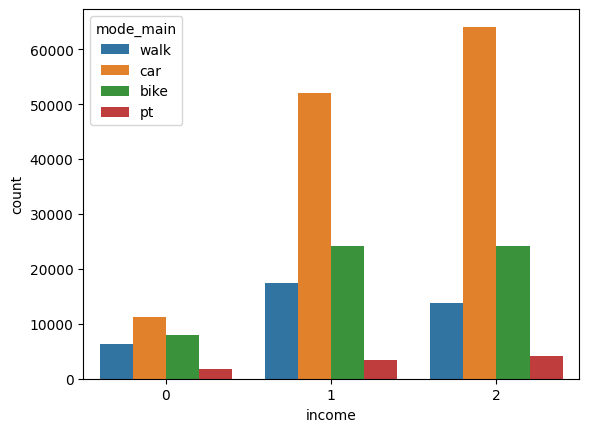

In [32]:
sns.countplot(x='income', data=df, hue="mode_main")
plt.show()

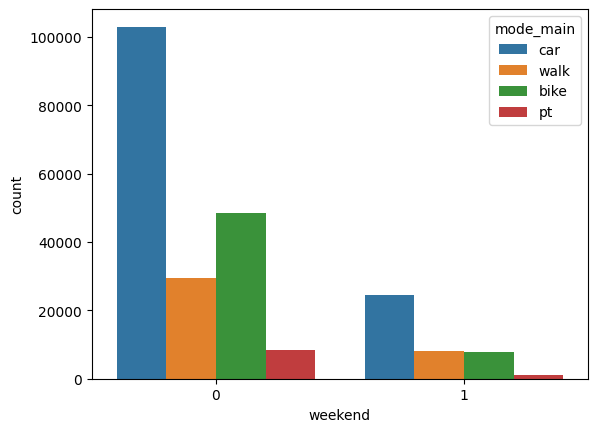

In [28]:
sns.countplot(x='weekend', data=df, hue="mode_main")
plt.show()

In [7]:
mapping = {
  "no":0,	
  "yes":1
}

df['weekend'] = df['weekend'].map(mapping)

In [8]:
mapping = {
   "less20":0,
   "20to40":1,
   "more40":2
}

df['income'] = df['income'].map(mapping)

In [9]:
mapping = {
   "native":0,
   "western":1,
   "nonwestern":2
}

df['ethnicity'] = df['ethnicity'].map(mapping)

In [10]:
mapping = {
   "lower":0,
   "middle":1,
   "higher":2
}

df['education'] = df['education'].map(mapping)

In [11]:
mapping = {
  "no":0,	
  "yes":1
}

df['male'] = df['male'].map(mapping)

In [12]:
mapping = {
  "no":0,	
  "yes":1
}

df['license'] = df['license'].map(mapping)

In [13]:
mapping = {
"bike": 0,
"car" : 1,
"pt" : 2,
"walk": 3
}

df['mode_main'] = df['mode_main'].map(mapping)

<Axes: >

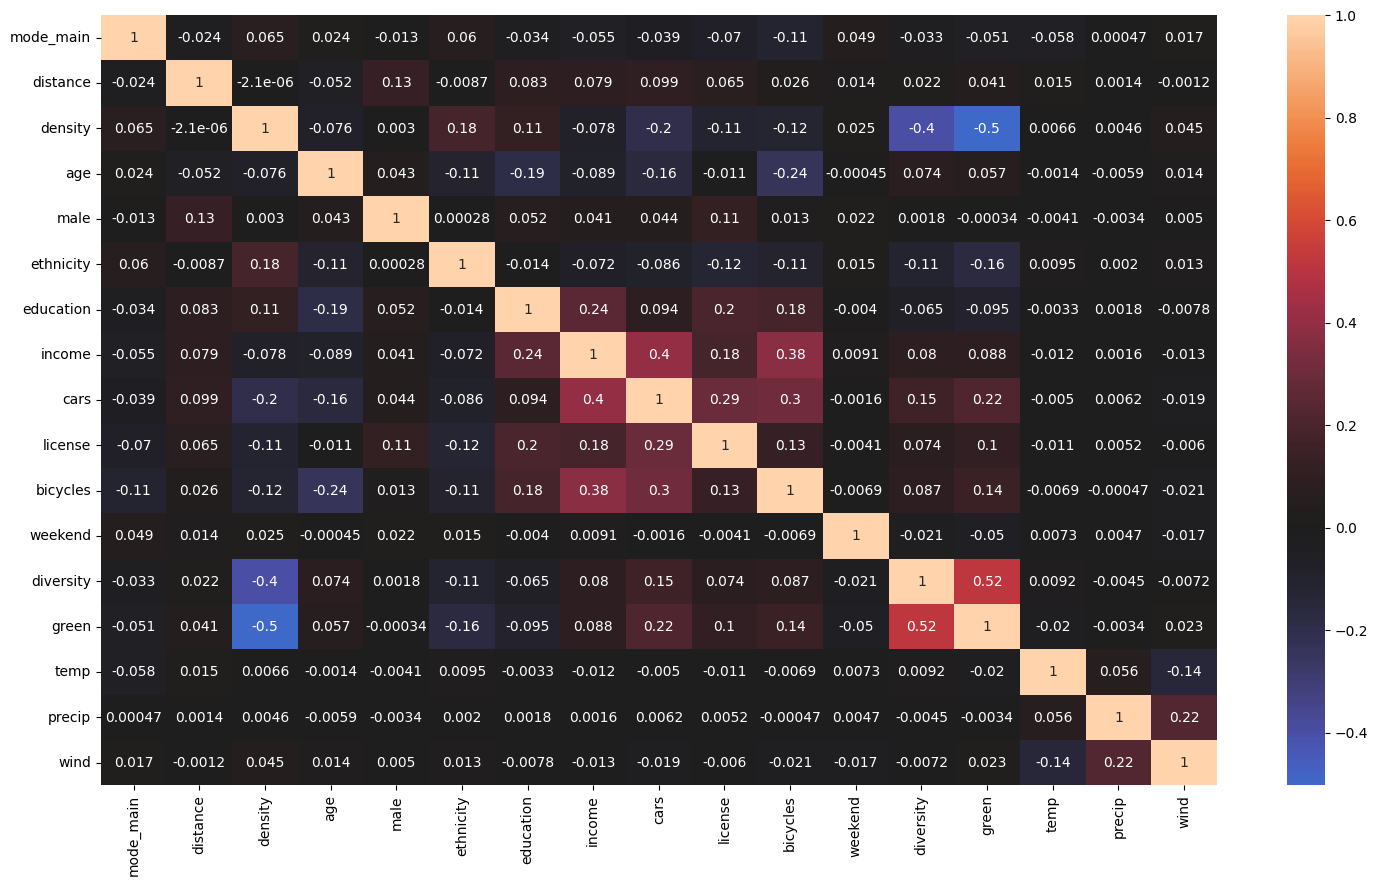

In [134]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(corrMatrix, annot=True, center=0, ax=ax)

In [14]:
dro=["mode_main"]
X = df.drop(dro, axis=1) 
y = df["mode_main"]
X

distance  density  age  male  ethnicity  education  income  cars  \
0            1.0  1.26259   84     0          0          0       0     0   
1           10.0  1.26259   84     0          0          0       0     0   
2            3.0  1.76264   27     1          1          1       1     1   
3            3.0  1.76264   27     1          1          1       1     1   
4           61.5  1.76264   27     1          1          1       1     1   
...          ...      ...  ...   ...        ...        ...     ...   ...   
230603       5.0  0.92743   59     0          0          0       1     1   
230604       2.0  0.92743   59     0          0          0       1     1   
230605       2.0  0.94175   57     0          0          0       1     1   
230606       8.0  0.94175   57     0          0          0       1     1   
230607       8.0  0.39012   57     0          0          0       1     1   

        license  bicycles  weekend  diversity      green  temp  precip  wind  
0             1         1        1    1.24604  26.881233   0.1    0.10   3.0  
1             1         1        1    1.24604  26.881233   0.1    0.10   3.0  
2             1         2        1    1.53959  36.045955  -3.4    0.05   1.8  
3             1         2        1    1.53959  36.045955  -3.4    0.05   1.8  
4             1         2        1    1.53959  36.045955  -3.4    0.05   1.8  
...         ...       ...      ...        ...        ...   ...     ...   ...  
230603        1         1        1    2.29996  57.150087  11.9    0.90   7.8  
230604        1         1        1    2.29996  57.150087  11.9    0.90   7.8  
230605        1         2        1    2.09674  71.413992  12.1    1.40   6.4  
230606        1         2        1    2.09674  71.413992  12.1    1.40   6.4  
230607        1         2        1    2.09674  71.413992  12.1    1.40   6.4  

[230608 rows x 16 columns]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state =23)

In [16]:
X_train.shape, y_train.shape

((207547, 16), (207547,))

In [23]:
X_test.shape, y_test.shape

((23061, 16), (23061,))

# DECISION TREE

In [140]:
pipeline = Pipeline(steps = [
    ('under_sampler', RandomUnderSampler(random_state=42)),
    ('classifier', dt_model)
])

In [141]:
param_grid = {
    'classifier__max_depth': list(range(3, 40)),
}

In [166]:
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring="recall_macro", n_jobs=-1)

In [167]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16, 17, 18,
                                                   19, 20, 21, 22, 23, 24, 25,
                                                   26, 27, 28, 29, 30, 31, 32, ...]},
             scoring='precision_macro')

In [168]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [169]:
results_df = pd.DataFrame({
    'Params': [str(params) for params in grid_search.cv_results_['params']],
    'Mean Validation Score': grid_search.cv_results_['mean_test_score'],
    'Rank': grid_search.cv_results_['rank_test_score']
})
results_df = results_df.sort_values(by='Mean Validation Score', ascending=False)

In [170]:
print("Top 10 Validation Scores and Parameters:")
print(results_df[['Params', 'Mean Validation Score']].head(10))

Top 10 Validation Scores and Parameters:
                           Params  Mean Validation Score
4    {'classifier__max_depth': 7}               0.507145
5    {'classifier__max_depth': 8}               0.506986
6    {'classifier__max_depth': 9}               0.502107
7   {'classifier__max_depth': 10}               0.500704
3    {'classifier__max_depth': 6}               0.500175
2    {'classifier__max_depth': 5}               0.495006
8   {'classifier__max_depth': 11}               0.493506
1    {'classifier__max_depth': 4}               0.492773
9   {'classifier__max_depth': 12}               0.491227
10  {'classifier__max_depth': 13}               0.484753


In [171]:
print(best_params)

{'classifier__max_depth': 7}


In [172]:
y_pred = best_model.predict(X_test)

In [173]:
tree_report_test = classification_report(y_test, y_pred)
print('depth = 17:', tree_report_test, sep='\n')

depth = 17:
              precision    recall  f1-score   support

           0       0.44      0.54      0.49      5747
           1       0.82      0.58      0.68     12580
           2       0.22      0.74      0.34       945
           3       0.51      0.55      0.53      3789

    accuracy                           0.57     23061
   macro avg       0.50      0.60      0.51     23061
weighted avg       0.65      0.57      0.59     23061



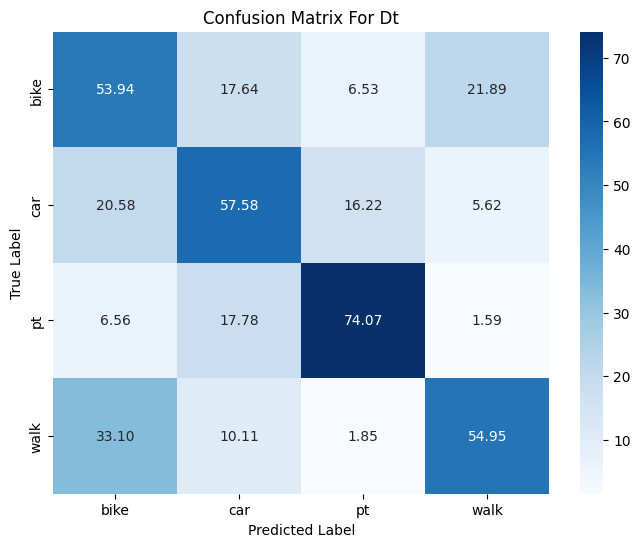

In [174]:
conf_matrix_tree = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
class_labels = ["bike", "car", "pt", "walk"]
class_accuracies = np.diag(conf_matrix_tree) / conf_matrix_tree.sum(axis=1)
conf_matrix_percentages_tree = (conf_matrix_tree.T / conf_matrix_tree.sum(axis=1)).T * 100
sns.heatmap(conf_matrix_percentages_tree, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix For Dt')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [175]:
class_probabilities_tree = best_model.predict_proba(X_test)
y_pred_prob_tree = np.argmax(class_probabilities_tree, axis=1)
print(y_pred_prob_tree)

[1 0 1 ... 2 3 3]


In [176]:
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(best_model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], class_probabilities_tree[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], class_probabilities_tree[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), class_probabilities_tree.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, class_probabilities_tree, average="micro")

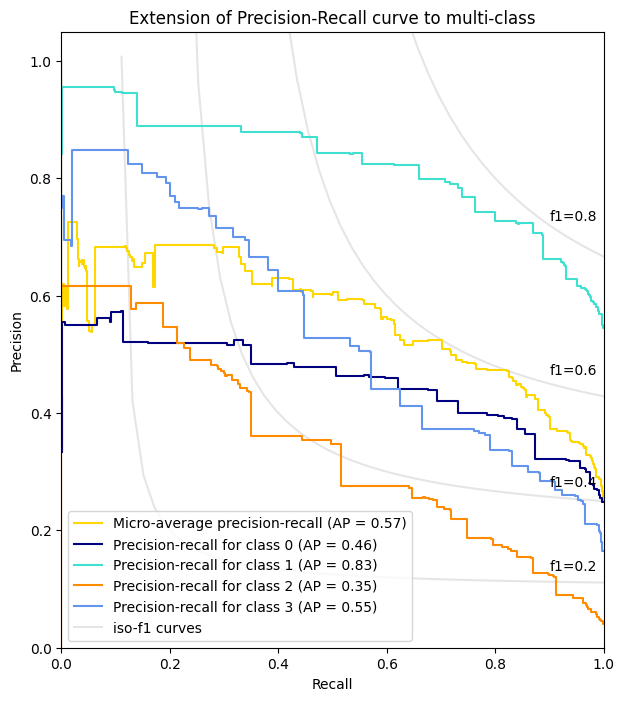

In [177]:
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(len(best_model.classes_)), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

# RANDOM FOREST

# MAX FEATURES TRIAL

In [162]:
rf_model = RandomForestClassifier(random_state=42)

In [163]:
pipeline = Pipeline(steps = [
    ('under_sampler', RandomUnderSampler(random_state=42, sampling_strategy = "auto")),
    ('classifier', rf_model)
])

In [164]:
param_grid = {
    'classifier__max_features': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
}

In [165]:
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

In [166]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_features': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17]},
             scoring='accuracy')

In [167]:
best_params = grid_search_rf.best_params_
best_model = grid_search_rf.best_estimator_

In [168]:
print(best_params)

{'classifier__max_features': 3}


In [169]:
results_rf = pd.DataFrame({
    'Params': [str(params) for params in grid_search_rf.cv_results_['params']],
    'Mean Validation Score': grid_search_rf.cv_results_['mean_test_score'],
    'Rank': grid_search_rf.cv_results_['rank_test_score']
})
results_rf = results_rf.sort_values(by='Mean Validation Score', ascending=False)

In [170]:
print("Top 10 Validation Scores and Parameters:")
print(results_rf[['Params', 'Mean Validation Score']].head(10))

Top 10 Validation Scores and Parameters:
                              Params  Mean Validation Score
1    {'classifier__max_features': 3}               0.630551
0    {'classifier__max_features': 2}               0.630016
2    {'classifier__max_features': 4}               0.629838
3    {'classifier__max_features': 5}               0.629241
4    {'classifier__max_features': 6}               0.628301
5    {'classifier__max_features': 7}               0.627482
6    {'classifier__max_features': 8}               0.626012
7    {'classifier__max_features': 9}               0.624962
8   {'classifier__max_features': 10}               0.624056
10  {'classifier__max_features': 12}               0.623555


# NUMBER OF ESTIMATORS TRIAL

In [156]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
}

In [157]:
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

In [158]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [50, 100, 150, 200, 250,
                                                      300, 350, 400, 450,
                                                      500]},
             scoring='accuracy')

In [159]:
best_params = grid_search_rf.best_params_
best_model = grid_search_rf.best_estimator_

In [160]:
results_rf = pd.DataFrame({
    'Params': [str(params) for params in grid_search_rf.cv_results_['params']],
    'Mean Validation Score': grid_search_rf.cv_results_['mean_test_score'],
    'Rank': grid_search_rf.cv_results_['rank_test_score']
})
results_rf = results_rf.sort_values(by='Mean Validation Score', ascending=False)

In [161]:
print("Top 10 Validation Scores and Parameters:")
print(results_rf[['Params', 'Mean Validation Score']].head(10))

Top 10 Validation Scores and Parameters:
                              Params  Mean Validation Score
7  {'classifier__n_estimators': 400}               0.633322
6  {'classifier__n_estimators': 350}               0.633302
5  {'classifier__n_estimators': 300}               0.633158
8  {'classifier__n_estimators': 450}               0.633153
9  {'classifier__n_estimators': 500}               0.633071
4  {'classifier__n_estimators': 250}               0.632816
3  {'classifier__n_estimators': 200}               0.631563
2  {'classifier__n_estimators': 150}               0.630980
1  {'classifier__n_estimators': 100}               0.629838
0   {'classifier__n_estimators': 50}               0.625034


# MAX SAMPLES TRIAL 

In [171]:
param_grid = {
    'classifier__max_samples': [0.5,0.6,0.7, 0.8, 0.9]
}

In [173]:
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_samples': [0.5, 0.6, 0.7, 0.8, 0.9]},
             scoring='accuracy')

In [174]:
best_params = grid_search_rf.best_params_
best_model = grid_search_rf.best_estimator_

In [175]:
results_rf = pd.DataFrame({
    'Params': [str(params) for params in grid_search_rf.cv_results_['params']],
    'Mean Validation Score': grid_search_rf.cv_results_['mean_test_score'],
    'Rank': grid_search_rf.cv_results_['rank_test_score']
})
results_rf = results_rf.sort_values(by='Mean Validation Score', ascending=False)

In [176]:
print("Top 10 Validation Scores and Parameters:")
print(results_rf[['Params', 'Mean Validation Score']].head(10))

Top 10 Validation Scores and Parameters:
                             Params  Mean Validation Score
4  {'classifier__max_samples': 0.9}               0.629785
3  {'classifier__max_samples': 0.8}               0.628084
2  {'classifier__max_samples': 0.7}               0.626928
1  {'classifier__max_samples': 0.6}               0.625338
0  {'classifier__max_samples': 0.5}               0.622606


# FINAL BUILD

In [177]:
param_grid = {
    'classifier__n_estimators': [300, 400, 450, 500, 550, 600],
    'classifier__max_features': [2,3,4,5]
}

In [178]:
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_features': [2, 3, 4, 5],
                         'classifier__n_estimators': [300, 400, 450, 500, 550,
                                                      600]},
             scoring='accuracy')

In [179]:
best_params = grid_search_rf.best_params_
best_model = grid_search_rf.best_estimator_

In [180]:
results_rf = pd.DataFrame({
    'Params': [str(params) for params in grid_search_rf.cv_results_['params']],
    'Mean Validation Score': grid_search_rf.cv_results_['mean_test_score'],
    'Rank': grid_search_rf.cv_results_['rank_test_score']
})
results_rf = results_rf.sort_values(by='Mean Validation Score', ascending=False)

In [182]:
print(best_params)

{'classifier__max_features': 2, 'classifier__n_estimators': 600}


In [183]:
print("Top 10 Validation Scores and Parameters:")
print(results_rf[['Params', 'Mean Validation Score']].head(10))

Top 10 Validation Scores and Parameters:
                                               Params  Mean Validation Score
5   {'classifier__max_features': 2, 'classifier__n...               0.635133
2   {'classifier__max_features': 2, 'classifier__n...               0.634940
4   {'classifier__max_features': 2, 'classifier__n...               0.634854
1   {'classifier__max_features': 2, 'classifier__n...               0.634757
3   {'classifier__max_features': 2, 'classifier__n...               0.634656
0   {'classifier__max_features': 2, 'classifier__n...               0.634372
7   {'classifier__max_features': 3, 'classifier__n...               0.634141
11  {'classifier__max_features': 3, 'classifier__n...               0.634136
10  {'classifier__max_features': 3, 'classifier__n...               0.633977
8   {'classifier__max_features': 3, 'classifier__n...               0.633948


In [184]:
y_pred_rf = best_model.predict(X_test)
rf_report_test = classification_report(y_test, y_pred_rf)
print(rf_report_test, sep='\n')

              precision    recall  f1-score   support

           0       0.56      0.59      0.57      5747
           1       0.87      0.63      0.73     12580
           2       0.30      0.89      0.45       945
           3       0.51      0.67      0.58      3789

    accuracy                           0.64     23061
   macro avg       0.56      0.69      0.58     23061
weighted avg       0.71      0.64      0.65     23061



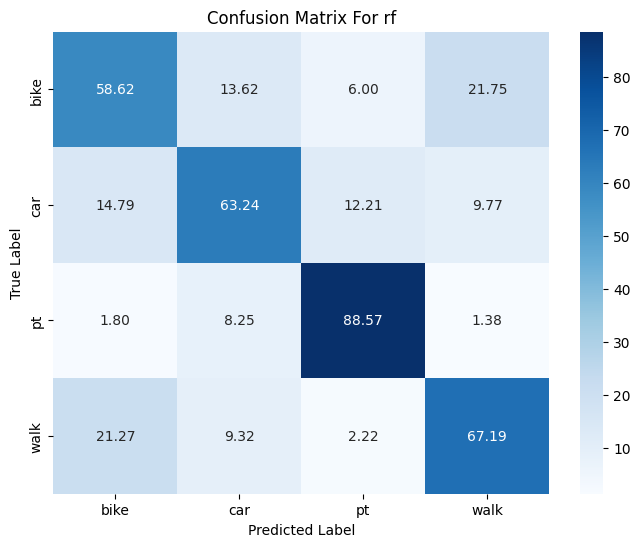

In [185]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
class_accuracies = np.diag(conf_matrix_rf) / conf_matrix_rf.sum(axis=1)
conf_matrix_percentages_rf = (conf_matrix_rf.T / conf_matrix_rf.sum(axis=1)).T * 100
sns.heatmap(conf_matrix_percentages_rf, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix For rf')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [187]:
class_probabilities_rf = best_model.predict_proba(X_test)
y_pred_prob_rf = np.argmax(class_probabilities_rf, axis=1)

In [191]:
y_test_bin_rf = label_binarize(y_test, classes=best_model.classes_)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(best_model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin_rf[:, i], class_probabilities_rf[:, i])
    average_precision[i] = average_precision_score(y_test_bin_rf[:, i], class_probabilities_rf[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin_rf.ravel(), class_probabilities_rf.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin_rf, class_probabilities_rf, average="micro")

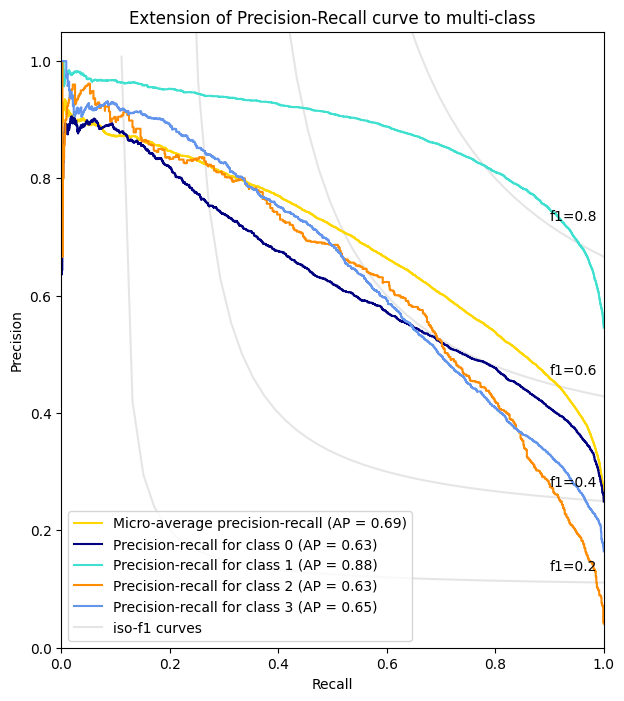

In [192]:
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(len(class_labels)), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

# LIGHTGBM

# LEARNING RATE

In [235]:
pipeline = Pipeline(steps = [
    ('under_sampler', RandomUnderSampler(random_state=42, sampling_strategy = "auto")), 
    ('classifier', lgb.LGBMClassifier(random_state=42, verbose = 0))
])

In [236]:
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

In [237]:
grid_search_lg = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lg.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        LGBMClassifier(random_state=42,
                                                       verbose=0))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.06, 0.07,
                                                       0.08, 0.09, 0.1]},
             scoring='accuracy')

In [238]:
best_params = grid_search_lg.best_params_
best_model = grid_search_lg.best_estimator_

In [239]:
results_lg = pd.DataFrame({
    'Params': [str(params) for params in grid_search_lg.cv_results_['params']],
    'Mean Validation Score': grid_search_lg.cv_results_['mean_test_score'],
    'Rank': grid_search_lg.cv_results_['rank_test_score']
})
results_lg = results_lg.sort_values(by='Mean Validation Score', ascending=False)

In [240]:
print("Top  Validation Scores and Parameters:")
print(results_lg[['Params', 'Mean Validation Score']].head(10))

Top  Validation Scores and Parameters:
                                Params  Mean Validation Score
6   {'classifier__learning_rate': 0.1}               0.613297
5  {'classifier__learning_rate': 0.09}               0.613100
4  {'classifier__learning_rate': 0.08}               0.612117
3  {'classifier__learning_rate': 0.07}               0.611447
2  {'classifier__learning_rate': 0.06}               0.610108
1  {'classifier__learning_rate': 0.05}               0.608922
0  {'classifier__learning_rate': 0.01}               0.592998


# Number of estimators

In [220]:
param_grid = {
    'classifier__n_estimators': [200, 300, 450, 500, 600]
}

In [221]:
grid_search_lg = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lg.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        LGBMClassifier(random_state=42,
                                                       verbose=0))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [200, 300, 450, 500, 600]},
             scoring='accuracy')

In [222]:
best_params = grid_search_lg.best_params_
best_model = grid_search_lg.best_estimator_

In [223]:
results_lg = pd.DataFrame({
    'Params': [str(params) for params in grid_search_lg.cv_results_['params']],
    'Mean Validation Score': grid_search_lg.cv_results_['mean_test_score'],
    'Rank': grid_search_lg.cv_results_['rank_test_score']
})
results_lg = results_lg.sort_values(by='Mean Validation Score', ascending=False)

In [224]:
print("Top  Validation Scores and Parameters:")
print(results_lg[['Params', 'Mean Validation Score']].head(10))

Top  Validation Scores and Parameters:
                              Params  Mean Validation Score
4  {'classifier__n_estimators': 600}               0.631886
3  {'classifier__n_estimators': 500}               0.630373
2  {'classifier__n_estimators': 450}               0.629033
1  {'classifier__n_estimators': 300}               0.624283
0  {'classifier__n_estimators': 200}               0.619334


In [264]:
param_grid = {
    'classifier__lambda_l1': [0, 0.1, 1],
}

In [265]:
grid_search_lg = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lg.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        LGBMClassifier(random_state=42,
                                                       verbose=0))]),
             n_jobs=-1, param_grid={'classifier__lambda_l1': [0, 0.1, 1]},
             scoring='accuracy')

In [266]:
best_params = grid_search_lg.best_params_
best_model = grid_search_lg.best_estimator_

In [267]:
results_lg = pd.DataFrame({
    'Params': [str(params) for params in grid_search_lg.cv_results_['params']],
    'Mean Validation Score': grid_search_lg.cv_results_['mean_test_score'],
    'Rank': grid_search_lg.cv_results_['rank_test_score']
})
results_lg = results_lg.sort_values(by='Mean Validation Score', ascending=False)

In [268]:
print(best_params)

{'classifier__lambda_l1': 0.1}


# Final

In [279]:
param_grid = {
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [ 300, 350, 400, 500, 600],
    'classifier__lambda_l1': [0.1]
}

In [280]:
grid_search_lg = GridSearchCV(pipeline, param_grid, cv=10, scoring='recall_micro', n_jobs=-1)
grid_search_lg.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('under_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        LGBMClassifier(random_state=42,
                                                       verbose=0))]),
             n_jobs=-1,
             param_grid={'classifier__lambda_l1': [0.1],
                         'classifier__learning_rate': [0.1],
                         'classifier__n_estimators': [300, 350, 400, 500, 600]},
             scoring='recall_micro')

In [281]:
best_params = grid_search_lg.best_params_
best_model = grid_search_lg.best_estimator_

In [282]:
results_lg = pd.DataFrame({
    'Params': [str(params) for params in grid_search_lg.cv_results_['params']],
    'Mean Validation Score': grid_search_lg.cv_results_['mean_test_score'],
    'Rank': grid_search_lg.cv_results_['rank_test_score']
})
results_lg = results_lg.sort_values(by='Mean Validation Score', ascending=False)

In [283]:
print(best_params)

{'classifier__lambda_l1': 0.1, 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 600}


In [284]:
y_pred_lg = best_model.predict(X_test)
lg_report_test = classification_report(y_test, y_pred_lg)
print(lg_report_test, sep='\n')

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      5747
           1       0.86      0.63      0.73     12580
           2       0.31      0.86      0.45       945
           3       0.52      0.65      0.58      3789

    accuracy                           0.64     23061
   macro avg       0.56      0.69      0.58     23061
weighted avg       0.70      0.64      0.65     23061



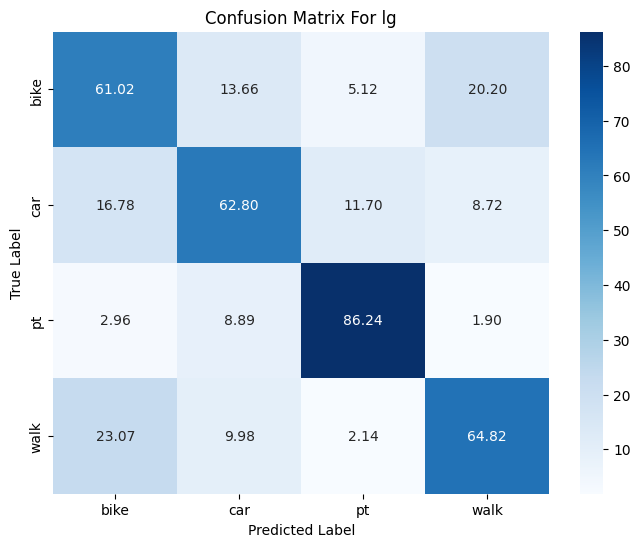

In [286]:
conf_matrix_lg = confusion_matrix(y_test, y_pred_lg)
plt.figure(figsize=(8, 6))
class_accuracies = np.diag(conf_matrix_lg) / conf_matrix_lg.sum(axis=1)
conf_matrix_percentages_lg = (conf_matrix_lg.T / conf_matrix_lg.sum(axis=1)).T * 100
sns.heatmap(conf_matrix_percentages_lg, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix For lg')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [288]:
class_probabilities_lg = best_model.predict_proba(X_test)
y_pred_prob_lg = np.argmax(class_probabilities_lg, axis=1)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


In [289]:
y_test_bin_lg = label_binarize(y_test, classes=best_model.classes_)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(best_model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin_lg[:, i], class_probabilities_lg[:, i])
    average_precision[i] = average_precision_score(y_test_bin_lg[:, i], class_probabilities_lg[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin_lg.ravel(), class_probabilities_lg.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin_lg, class_probabilities_lg, average="micro")

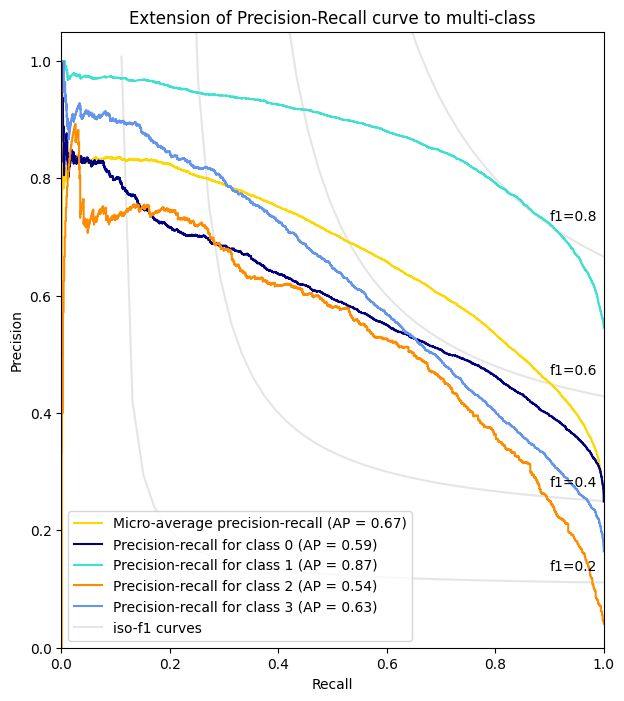

In [290]:
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(len(class_labels)), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

# OVERSAMPLING

# DECISION TREE

In [33]:
dt_model = DecisionTreeClassifier(random_state=42)

In [34]:
pipeline2 = Pipeline(steps = [
    ('over_sampler', RandomOverSampler(random_state=42, sampling_strategy = "auto")),
    ('classifier', dt_model)
])

In [35]:
param_grid = {
    'classifier__max_depth': list(range(3, 21)),
}

In [36]:
grid_search = GridSearchCV(pipeline2, param_grid, cv=10, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over_sampler',
                                        RandomOverSampler(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16, 17, 18,
                                                   19, 20]},
             scoring='accuracy')

In [37]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [38]:
results_df = pd.DataFrame({
    'Params': [str(params) for params in grid_search.cv_results_['params']],
    'Mean Validation Score': grid_search.cv_results_['mean_test_score'],
    'Rank': grid_search.cv_results_['rank_test_score']
})
results_df = results_df.sort_values(by='Mean Validation Score', ascending=False)

In [39]:
print("Top 10 Validation Scores and Parameters:")
print(results_df[['Params', 'Mean Validation Score']].head(10))

Top 10 Validation Scores and Parameters:
                           Params  Mean Validation Score
17  {'classifier__max_depth': 20}               0.679196
16  {'classifier__max_depth': 19}               0.666427
15  {'classifier__max_depth': 18}               0.652643
14  {'classifier__max_depth': 17}               0.640279
13  {'classifier__max_depth': 16}               0.629761
12  {'classifier__max_depth': 15}               0.622375
11  {'classifier__max_depth': 14}               0.612473
10  {'classifier__max_depth': 13}               0.605444
9   {'classifier__max_depth': 12}               0.599406
7   {'classifier__max_depth': 10}               0.598096


In [40]:
y_pred = best_model.predict(X_test)
tree_report_test = classification_report(y_test, y_pred)
print('depth = 17:', tree_report_test, sep='\n')

depth = 17:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      5747
           1       0.84      0.71      0.77     12580
           2       0.36      0.59      0.45       945
           3       0.58      0.64      0.61      3789

    accuracy                           0.69     23061
   macro avg       0.59      0.66      0.61     23061
weighted avg       0.71      0.69      0.69     23061



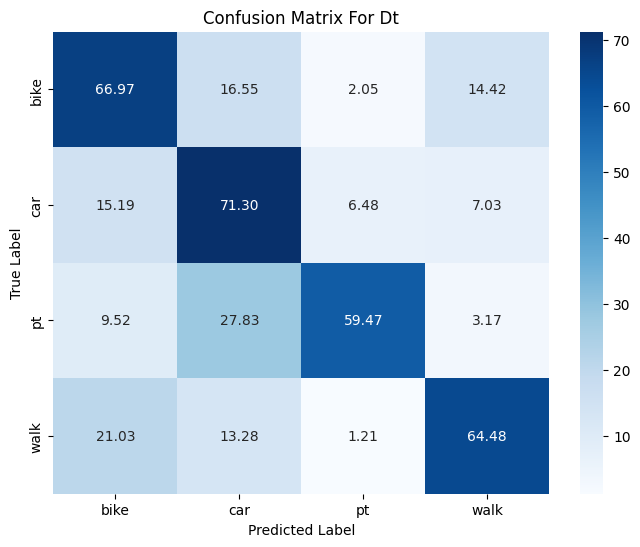

In [41]:
conf_matrix_tree = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
class_labels = ["bike", "car", "pt", "walk"]
class_accuracies = np.diag(conf_matrix_tree) / conf_matrix_tree.sum(axis=1)
conf_matrix_percentages_tree = (conf_matrix_tree.T / conf_matrix_tree.sum(axis=1)).T * 100
sns.heatmap(conf_matrix_percentages_tree, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix For Dt')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
class_probabilities_tree = best_model.predict_proba(X_test)
y_pred_prob_tree = np.argmax(class_probabilities_tree, axis=1)

In [43]:
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(best_model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], class_probabilities_tree[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], class_probabilities_tree[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), class_probabilities_tree.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, class_probabilities_tree, average="micro")

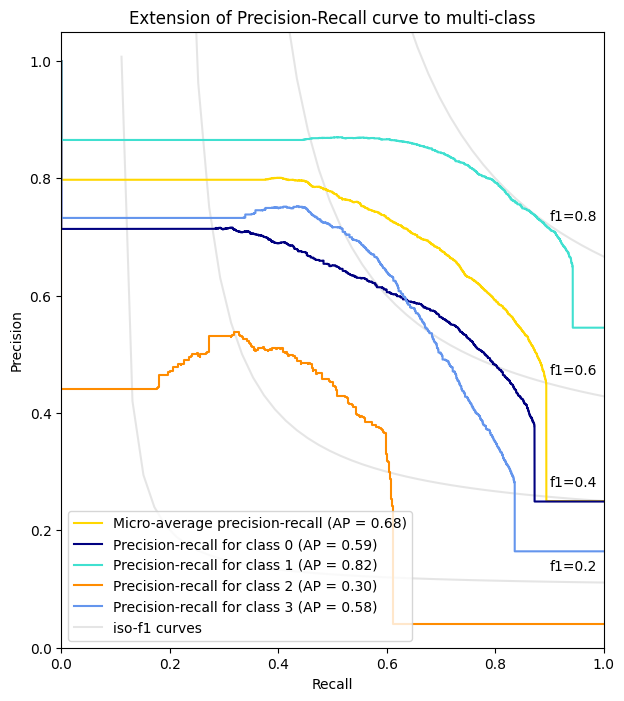

In [44]:
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(len(best_model.classes_)), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

# Random Forest

In [36]:
rf_model = RandomForestClassifier(random_state=42)

In [37]:
pipeline2 = Pipeline(steps = [
    ('over_over', RandomOverSampler(random_state=42, sampling_strategy = "auto")),
    ('classifier', rf_model)
])

In [38]:
param_grid = {
    'classifier__n_estimators': [300, 400, 450, 500, 550, 600]
}

In [39]:
grid_search = GridSearchCV(pipeline2, param_grid, cv=10, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 